In [684]:
de=(2251262576%15)+1
de


12

In [685]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import time
# from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from numpy.random import choice
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

In [686]:
df=pd.read_csv('seattle-weather.csv')

In [687]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [688]:
le=LabelEncoder()
df['weather_encoder']=le.fit_transform(df['weather'])


In [689]:
# Lấy các cột quan sát
observations=df[['precipitation','temp_max','wind']].values
states=df['weather_encoder'].values

In [690]:
#Chia dữ liệu thành tập huấn luyện và kiếm tra
train_size = int(0.8 * len(df))
train_observations = observations[:train_size]
test_observations = observations[train_size:]
train_states = states[:train_size]
test_states = states[train_size:]

In [691]:
start_time_em=time.time()

In [692]:
#Khởi tạo mô hình HMM
n_states = len(np.unique(states))
model_em=hmm.GaussianHMM(n_components=n_states,covariance_type='full',n_iter=100,random_state=42)
model_em.fit(train_observations)


GaussianHMM(covariance_type='full', n_components=5, n_iter=100, random_state=42)

In [693]:
em_preds = model_em.predict(test_observations)
cm = confusion_matrix(test_states, em_preds)

# 2. Dùng thuật toán Hungarian để tìm ánh xạ tối ưu
row_ind, col_ind = linear_sum_assignment(-cm)  # dấu trừ vì cần maximize matching

# 3. Tạo ánh xạ từ nhãn EM sang nhãn thật
mapping = dict(zip(col_ind, row_ind))

# 4. Đổi lại nhãn EM theo ánh xạ
em_preds_aligned = np.array([mapping[p] for p in em_preds])

# 5. Tính lại accuracy
em_acc= accuracy_score(test_states, em_preds_aligned)
print("EM Accuracy (aligned):", em_acc)

EM Accuracy (aligned): 0.621160409556314


In [694]:
# Tính thời gian huấn luyện
time_em=time.time()-start_time_em

In [695]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


In [696]:

class ParticleFilterHMM:
    def __init__(self, n_states, n_particles=100):
        self.n_states = n_states
        self.n_particles = n_particles

    def initialize(self, observations, states):
        # Khởi tạo xác suất ban đầu, ma trận chuyển tiếp và phân phối quan sát
        self.start_prob = np.bincount(states[:10], minlength=self.n_states) / 10
        self.trans_mat = np.zeros((self.n_states, self.n_states))
        for i in range(len(states) - 1):
            self.trans_mat[states[i], states[i + 1]] += 1
        self.trans_mat = (self.trans_mat.T / np.sum(self.trans_mat, axis=1)).T

        self.means = np.zeros((self.n_states, observations.shape[1]))
        self.covs = np.zeros((self.n_states, observations.shape[1], observations.shape[1]))
        for s in range(self.n_states):
            obs_s = observations[states == s]
            self.means[s] = np.mean(obs_s, axis=0)
            self.covs[s] = np.cov(obs_s.T) + np.eye(observations.shape[1]) * 1e-6

    def particle_filter(self, observations):
        T = len(observations)
        particles = choice(self.n_states, size=self.n_particles, p=self.start_prob)
        weights = np.ones(self.n_particles) / self.n_particles
        estimated_states = []

        for t in range(T):
            obs = observations[t]
            # Dự đoán bước tiếp theo bằng ma trận chuyển tiếp
            new_particles = np.array([choice(self.n_states, p=self.trans_mat[s]) for s in particles])
            
            # Tính trọng số dựa trên xác suất quan sát
            for i, s in enumerate(new_particles):
                try:
                    mean = self.means[s]
                    cov = self.covs[s]
                    diff = obs - mean
                    likelihood = np.exp(-0.5 * diff.T @ np.linalg.inv(cov) @ diff)
                    likelihood /= np.sqrt((2 * np.pi)**len(obs) * np.linalg.det(cov))
                except:
                    likelihood = 1e-6
                weights[i] *= likelihood

            # Chuẩn hóa trọng số
            weights += 1e-300  # tránh chia cho 0
            weights /= np.sum(weights)

            # Ước lượng trạng thái: mode hoặc expectation
            estimated_state = np.bincount(new_particles, weights=weights).argmax()
            estimated_states.append(estimated_state)

            # Resample
            indices = choice(range(self.n_particles), size=self.n_particles, p=weights)
            particles = new_particles[indices]
            weights = np.ones(self.n_particles) / self.n_particles

        return estimated_states

# ===================
# Huấn luyện và dự đoán
# ===================

n_states = len(np.unique(states))
pf_hmm = ParticleFilterHMM(n_states=n_states, n_particles=200)
pf_hmm.initialize(train_observations, train_states)
predicted_states = pf_hmm.particle_filter(test_observations)

# ===================
# Đánh giá
# ===================
from sklearn.metrics import accuracy_score
pf_acc=accuracy_score(test_states, predicted_states)

print("Accuracy:",pf_acc )

Accuracy: 0.8600682593856656


So sánh độ chính xác HMM:
 HMM với EM (Baum-Welch):       0.6212
 HMM với Particle Filter (MC):  0.8601


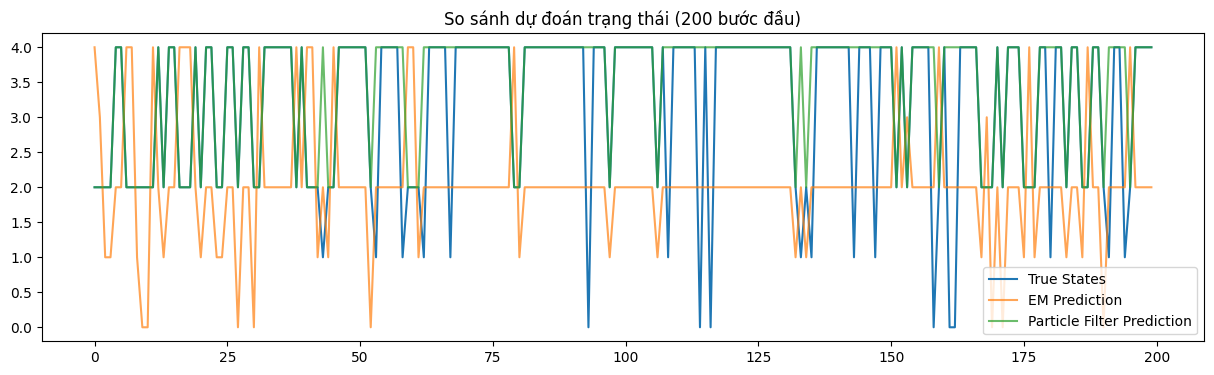

In [697]:
print("So sánh độ chính xác HMM:")
print(f" HMM với EM (Baum-Welch):       {em_acc:.4f}")
print(f" HMM với Particle Filter (MC):  {pf_acc:.4f}")

# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(15, 4))
plt.plot(test_states[:200], label='True States')
plt.plot(em_preds[:200], label='EM Prediction', alpha=0.7)
plt.plot(predicted_states[:200], label='Particle Filter Prediction', alpha=0.7)
plt.legend()
plt.title("So sánh dự đoán trạng thái (200 bước đầu)")
plt.show()